# Segmentación de usuarios de app de streaming

Importar librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
sns.set(style="whitegrid")

Cargar datos

In [2]:
# Cargar datos
df = pd.read_csv('streaming_kmeans.csv')
df.head()

,horas_semana,generos_distintos,antiguedad_meses,dispositivos_usados,gasto_mensual
0,12.483571,8,22,2,15
1,9.308678,14,57,2,0
2,13.238443,4,20,2,0
3,17.615149,14,50,4,10
4,8.829233,1,43,4,15


EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   horas_semana         2200 non-null   float64
 1   generos_distintos    2200 non-null   int64  
 2   antiguedad_meses     2200 non-null   int64  
 3   dispositivos_usados  2200 non-null   int64  
 4   gasto_mensual        2200 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 86.1 KB
Valores nulos:
 horas_semana           0
generos_distintos      0
antiguedad_meses       0
dispositivos_usados    0
gasto_mensual          0
dtype: int64


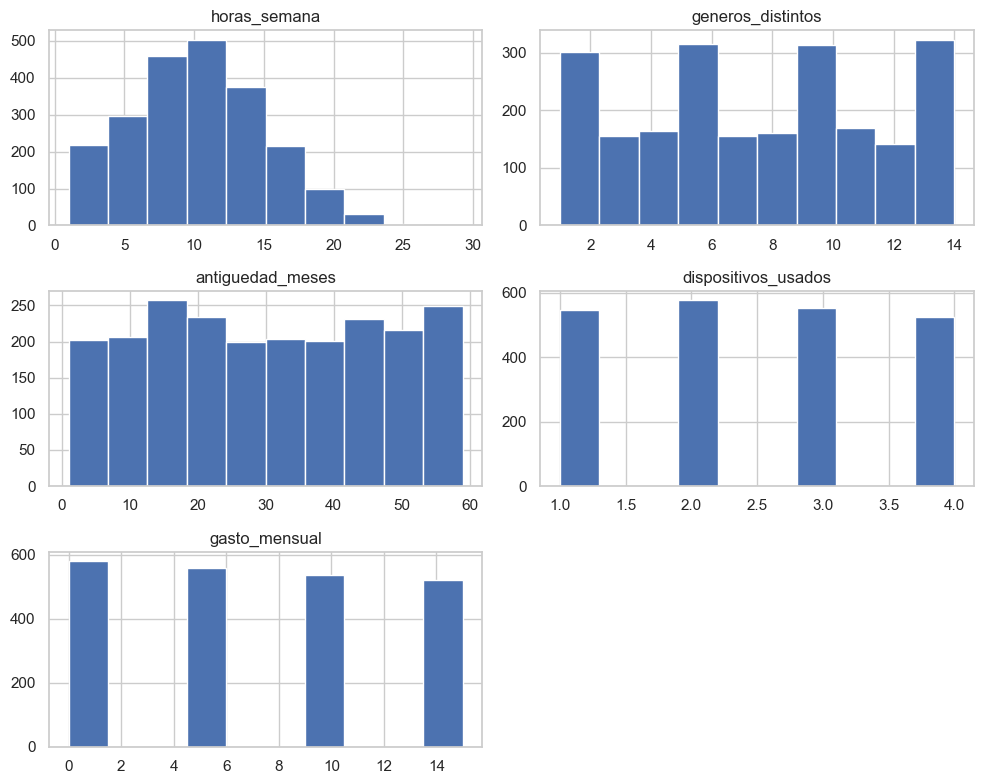

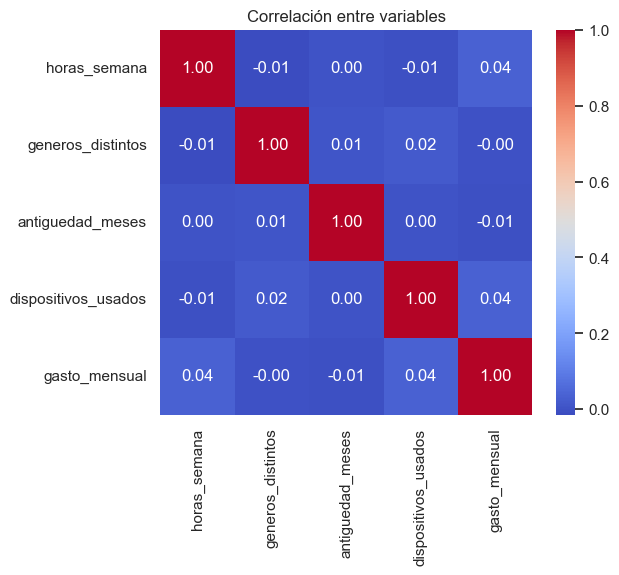

In [3]:
# EDA
df.info()
df.describe().T
print('Valores nulos:\n', df.isnull().sum())

# Distribuciones
df.hist(figsize=(10,8));
plt.tight_layout()

# Correlación
plt.figure(figsize=(6,5))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlación entre variables')
plt.show()

Escalar

In [4]:
# Escalado
X = df.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,horas_semana,generos_distintos,antiguedad_meses,dispositivos_usados,gasto_mensual
0,0.468473,0.116593,-0.489575,-0.434404,1.380143
1,-0.193646,1.610794,1.572412,-0.434404,-1.301324
2,0.625901,-0.879541,-0.607402,-0.434404,-1.301324
3,1.538657,1.610794,1.160015,1.373901,0.486321
4,-0.293633,-1.626641,0.747618,1.373901,1.380143


Método del codo

k óptimo por silhouette: 10


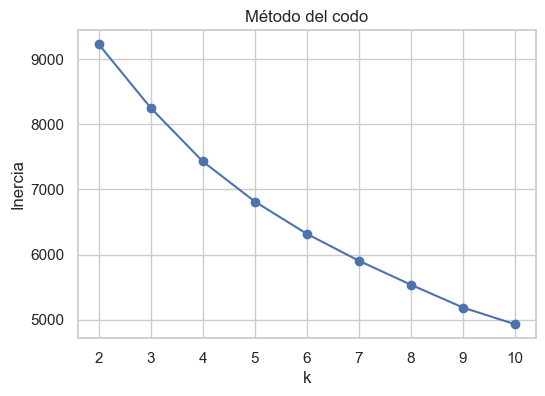

In [15]:
# Método del codo e índice de silhouette
inertias = []
silhs = []
K = range(2,11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
    silhs.append(silhouette_score(X_scaled, km.labels_))

plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
plt.plot(K, inertias, marker='o')
plt.xlabel('k')
plt.ylabel('Inercia')
plt.title('Método del codo')



best_k = K[int(np.argmax(silhs))]
print('k óptimo por silhouette:', best_k)

Modelo final

In [6]:
# Modelo final con k óptimo
k_final = int(best_k) if 'best_k' in globals() else 3
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=10)
kmeans.fit(X_scaled)
df['cluster'] = kmeans.labels_
print(df['cluster'].value_counts())

cluster
1    240
3    239
0    232
6    228
7    223
9    219
4    211
8    209
5    205
2    194
Name: count, dtype: int64


Perfil de usuarios

In [7]:
# Perfil de usuarios por cluster (centros en escala original)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=X.columns)
display(centers_df)

for c in sorted(df['cluster'].unique()):
    print(f'--- Cluster {c} ---')
    display(df[df['cluster']==c].describe().T)

,horas_semana,generos_distintos,antiguedad_meses,dispositivos_usados,gasto_mensual
0,12.534473,4.146552,16.275862,1.573276,3.642241
1,9.560932,4.712500,41.133333,3.329167,1.687500
2,13.943257,10.644330,16.917526,3.525773,4.871134
3,7.238947,11.058577,43.489540,3.435146,10.104603
4,6.435956,4.142857,40.828571,1.423810,9.238095
5,6.134768,10.629268,16.848780,2.092683,2.707317
6,11.044094,10.837719,20.644737,1.675439,13.355263
7,15.620051,5.520179,42.560538,2.780269,12.399103
8,11.965642,10.309524,45.928571,1.566667,3.047619
9,8.040506,3.894977,15.922374,3.328767,11.232877


--- Cluster 0 ---


,count,mean,std,min,25%,50%,75%,max
horas_semana,232.0,12.534473,3.799390,1.725717,9.78765,12.546468,14.801486,23.008416
generos_distintos,232.0,4.146552,2.448621,1.000000,2.00000,4.000000,6.000000,11.000000
antiguedad_meses,232.0,16.275862,9.974501,1.000000,7.75000,16.000000,23.000000,45.000000
dispositivos_usados,232.0,1.573276,0.653841,1.000000,1.00000,1.000000,2.000000,3.000000
gasto_mensual,232.0,3.642241,3.602131,0.000000,0.00000,5.000000,5.000000,15.000000
cluster,232.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


--- Cluster 1 ---


,count,mean,std,min,25%,50%,75%,max
horas_semana,240.0,9.560932,3.710209,1.0,6.792585,9.773106,11.950509,19.694645
generos_distintos,240.0,4.712500,2.580229,1.0,3.000000,5.000000,7.000000,11.000000
antiguedad_meses,240.0,41.133333,12.657664,7.0,32.000000,43.000000,52.000000,59.000000
dispositivos_usados,240.0,3.329167,0.681482,2.0,3.000000,3.000000,4.000000,4.000000
gasto_mensual,240.0,1.687500,2.620775,0.0,0.000000,0.000000,5.000000,10.000000
cluster,240.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000


--- Cluster 2 ---


,count,mean,std,min,25%,50%,75%,max
horas_semana,194.0,13.943257,3.553562,6.746787,11.220475,13.87772,16.015084,23.7983
generos_distintos,194.0,10.644330,2.555558,4.000000,9.000000,11.00000,13.000000,14.0000
antiguedad_meses,194.0,16.917526,10.414886,1.000000,8.250000,16.00000,23.000000,45.0000
dispositivos_usados,194.0,3.525773,0.620760,2.000000,3.000000,4.00000,4.000000,4.0000
gasto_mensual,194.0,4.871134,4.449939,0.000000,0.000000,5.00000,10.000000,15.0000
cluster,194.0,2.000000,0.000000,2.000000,2.000000,2.00000,2.000000,2.0000


--- Cluster 3 ---


,count,mean,std,min,25%,50%,75%,max
horas_semana,239.0,7.238947,3.843159,1.0,4.327331,6.996807,10.154401,17.615149
generos_distintos,239.0,11.058577,2.391494,3.0,10.000000,11.000000,13.000000,14.000000
antiguedad_meses,239.0,43.489540,11.061654,11.0,36.000000,45.000000,53.000000,59.000000
dispositivos_usados,239.0,3.435146,0.657039,1.0,3.000000,4.000000,4.000000,4.000000
gasto_mensual,239.0,10.104603,4.334920,0.0,10.000000,10.000000,15.000000,15.000000
cluster,239.0,3.000000,0.000000,3.0,3.000000,3.000000,3.000000,3.000000


--- Cluster 4 ---


,count,mean,std,min,25%,50%,75%,max
horas_semana,211.0,6.436515,3.331360,1.0,3.880266,6.461653,8.934872,13.352403
generos_distintos,211.0,4.161137,2.328418,1.0,2.000000,4.000000,6.000000,11.000000
antiguedad_meses,211.0,40.853081,12.113441,4.0,34.000000,43.000000,50.000000,59.000000
dispositivos_usados,211.0,1.426540,0.575745,1.0,1.000000,1.000000,2.000000,3.000000
gasto_mensual,211.0,9.218009,4.627028,0.0,5.000000,10.000000,15.000000,15.000000
cluster,211.0,4.000000,0.000000,4.0,4.000000,4.000000,4.000000,4.000000


--- Cluster 5 ---


,count,mean,std,min,25%,50%,75%,max
horas_semana,205.0,6.134768,3.267372,1.0,3.602115,6.287647,8.702267,13.409457
generos_distintos,205.0,10.629268,2.386466,4.0,9.000000,11.000000,12.000000,14.000000
antiguedad_meses,205.0,16.848780,10.536192,1.0,9.000000,16.000000,25.000000,47.000000
dispositivos_usados,205.0,2.092683,0.894534,1.0,1.000000,2.000000,3.000000,4.000000
gasto_mensual,205.0,2.707317,3.069808,0.0,0.000000,0.000000,5.000000,10.000000
cluster,205.0,5.000000,0.000000,5.0,5.000000,5.000000,5.000000,5.000000


--- Cluster 6 ---


,count,mean,std,min,25%,50%,75%,max
horas_semana,228.0,11.044094,3.890342,1.0,8.381721,11.044616,13.333212,25.688743
generos_distintos,228.0,10.837719,2.446787,4.0,9.000000,11.000000,13.000000,14.000000
antiguedad_meses,228.0,20.644737,12.192694,1.0,11.000000,20.000000,29.000000,58.000000
dispositivos_usados,228.0,1.675439,0.702364,1.0,1.000000,2.000000,2.000000,3.000000
gasto_mensual,228.0,13.355263,2.446092,5.0,10.000000,15.000000,15.000000,15.000000
cluster,228.0,6.000000,0.000000,6.0,6.000000,6.000000,6.000000,6.000000


--- Cluster 7 ---


,count,mean,std,min,25%,50%,75%,max
horas_semana,223.0,15.620051,3.699234,8.041757,12.824419,15.620564,18.119467,29.263657
generos_distintos,223.0,5.520179,2.975621,1.000000,3.000000,5.000000,8.000000,13.000000
antiguedad_meses,223.0,42.560538,12.195652,6.000000,34.000000,44.000000,53.000000,59.000000
dispositivos_usados,223.0,2.780269,0.959150,1.000000,2.000000,3.000000,4.000000,4.000000
gasto_mensual,223.0,12.399103,3.212784,0.000000,10.000000,15.000000,15.000000,15.000000
cluster,223.0,7.000000,0.000000,7.000000,7.000000,7.000000,7.000000,7.000000


--- Cluster 8 ---


,count,mean,std,min,25%,50%,75%,max
horas_semana,209.0,11.991535,3.919062,1.0,9.421759,11.886502,14.819396,22.276501
generos_distintos,209.0,10.320574,2.560350,3.0,8.000000,11.000000,13.000000,14.000000
antiguedad_meses,209.0,45.928230,9.487320,17.0,39.000000,47.000000,54.000000,59.000000
dispositivos_usados,209.0,1.564593,0.655516,1.0,1.000000,1.000000,2.000000,3.000000
gasto_mensual,209.0,3.038278,3.532605,0.0,0.000000,0.000000,5.000000,15.000000
cluster,209.0,8.000000,0.000000,8.0,8.000000,8.000000,8.000000,8.000000


--- Cluster 9 ---


,count,mean,std,min,25%,50%,75%,max
horas_semana,219.0,8.040506,3.631359,1.0,5.442579,8.173392,10.101551,18.349523
generos_distintos,219.0,3.894977,2.334999,1.0,2.000000,4.000000,6.000000,10.000000
antiguedad_meses,219.0,15.922374,9.993503,1.0,8.000000,15.000000,23.000000,43.000000
dispositivos_usados,219.0,3.328767,0.698389,2.0,3.000000,3.000000,4.000000,4.000000
gasto_mensual,219.0,11.232877,3.781366,5.0,10.000000,10.000000,15.000000,15.000000
cluster,219.0,9.000000,0.000000,9.0,9.000000,9.000000,9.000000,9.000000


Visualización

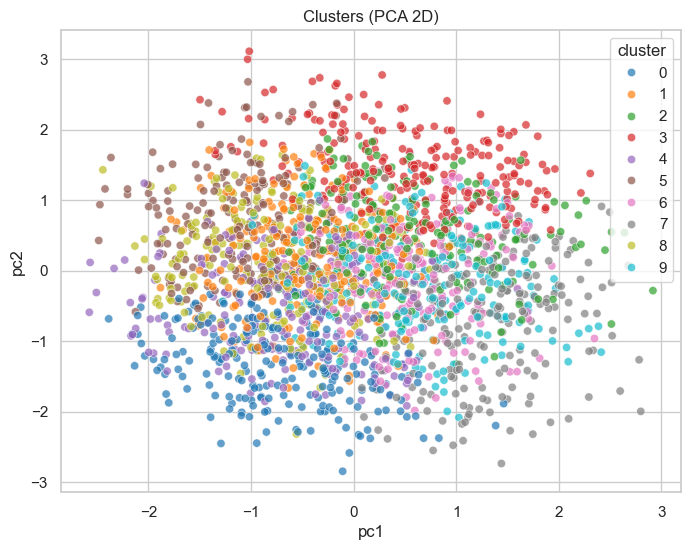

In [8]:
# Visualización con PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df['pc1'] = X_pca[:,0]
df['pc2'] = X_pca[:,1]
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='pc1', y='pc2', hue='cluster', palette='tab10', alpha=0.7)
plt.title('Clusters (PCA 2D)')
plt.show()